# Model used in object detection

In [20]:
import os
import sys
import random
import pickle
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from timeit import default_timer as timer
from torch.utils.data import Dataset, DataLoader,random_split
import numpy as np
import gc

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import subplots

#from scipy.spatial import distance

import torchvision
import torchvision.transforms as transforms

### Training function

In [21]:
def train_for_classification(net, train_loader, test_loader, optimizer, 
                             criterion, lr_scheduler=None,
                             epochs=1, reports_every=1, device='cuda'):
  net.to(device)
  total_train = len(train_loader.dataset)
  total_test = len(test_loader.dataset)
  tiempo_epochs = 0
  train_loss, train_acc, test_acc = [], [], []

  for e in range(1,epochs+1):  
    inicio_epoch = timer()
    
    # Aseguramos que todos los parámetros se entrenarán usando .train()
    net.train()
    print(0)

    # Variables para las métricas
    running_loss, running_acc = 0.0, 0.0

    for i, data in enumerate(train_loader):
      # Desagregamos los datos y los pasamos a la GPU
      X, Y = data
      X, Y = X.to(device), Y.to(device)
      print(1)

      # Limpiamos los gradientes, pasamos el input por la red, calculamos
      # la loss, ejecutamos el backpropagation (.backward) 
      # y un paso del optimizador para modificar los parámetros
      optimizer.zero_grad()

      out_dict = net(X)
      Y_logits = out_dict['logits']
      loss = criterion(Y_logits, Y)

      # Si hay logits auxiliares considéralos en la loss promediando
      # loss calculada para cada logit (incluyendo el anterior ya calculado)
      if 'aux_logits' in out_dict:
        aux_logits_list = out_dict['aux_logits']
        N = len(aux_logits_list)
        for aux_logits in aux_logits_list:
          loss += criterion(aux_logits, Y)
        loss /= (N + 1)

      print(3)
      loss.backward()
      optimizer.step()
      print(4)
      # loss
      items = min(total_train, (i+1) * train_loader.batch_size)
      running_loss += loss.item()
      avg_loss = running_loss/(i+1)
      
      # accuracy
      _, max_idx = torch.max(Y_logits, dim=1)
      running_acc += torch.sum(max_idx == Y).item()
      avg_acc = running_acc/items*100
      print(5)
      # report
      sys.stdout.write(f'\rEpoch:{e}({items}/{total_train}), ' 
                       + (f'lr:{lr_scheduler.get_last_lr()[0]:02.7f}, ' if lr_scheduler is not None else '')
                       + f'Loss:{avg_loss:02.5f}, '
                       + f'Train Accuracy:{avg_acc:02.1f}%')
      gc.collect()
      torch.cuda.empty_cache()
    tiempo_epochs += timer() - inicio_epoch

    if e % reports_every == 0:
      sys.stdout.write(', Validating...')
      train_loss.append(avg_loss)
      train_acc.append(avg_acc)

      net.eval()
      with torch.no_grad():
        running_acc = 0.0
        for i, data in enumerate(test_loader):
          X, Y = data
          X, Y = X.to(device), Y.to(device)
          Y_logits = net(X)['logits']
          _, max_idx = torch.max(Y_logits, dim=1)
          running_acc += torch.sum(max_idx == Y).item()
          avg_acc = running_acc/total_test*100
        test_acc.append(avg_acc)
        sys.stdout.write(f', Val Acc:{avg_acc:02.2f}%, '
                        + f'Avg-Time:{tiempo_epochs/e:.3f}s.\n')
    else:
      sys.stdout.write('\n')

    if lr_scheduler is not None:
      lr_scheduler.step()

  return train_loss, (train_acc, test_acc)

## Loading and creating the dataset

In [22]:
class ObjectLoader(Dataset):
    def __init__(self,data,transforms):
        super(ObjectLoader,self).__init__()
        self.data = data
        self.labels = data[:,1]
        self.imgs = data[:,0]
        self.transforms = transforms
        self.lables_list =list(set(data[:,1]))
        self.label_dict = {elem:i for i,elem in enumerate(self.lables_list)}
        self.transform_data()
    def transform_data(self):
        prev = self.imgs.copy()
        self.imgs = torch.zeros((len(prev),3,32,32))
        for i in range(len(prev)):
            cur = prev[i]
            temp =self.labels[i] 
            self.labels[i] = self.label_dict[temp]
            for tr in self.transforms:
                cur  = tr(cur)
            self.imgs[i]+= cur
        


    def __getitem__(self,idx):
        img ,label= self.imgs[idx], self.labels[idx]
        return img,label
    def __len__(self):
        return len(self.imgs)


In [23]:
#Creating the dataset.
from PIL import Image
data = np.load("dataset/final_data/np_data.npy",allow_pickle= True)
trs= [lambda x : Image.fromarray(np.uint8(x)).convert('RGB'),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
dataset = ObjectLoader(data,trs)


data_size = len(dataset)
train_size = int(data_size*0.8)
test_size = data_size - train_size
trainset,testset = random_split(dataset,[train_size,test_size])
print("Number of elements in dataset :",data_size)
print(f"Training with: {train_size} and testing with: {test_size}")


Number of elements in dataset : 2110
Training with: 1688 and testing with: 422


(32, 32, 3)
(32, 32, 3)


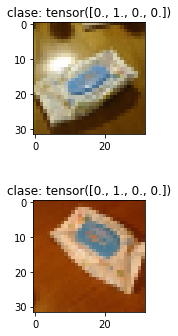

In [24]:
#SOME DATA EXAMPLES
import torchvision.transforms as T
n_examples = 2
fig, axs = subplots(nrows=n_examples, figsize=(2,n_examples*3))
for i in range(n_examples):
    img,label = random.choice(dataset.data)
    print(img.shape)
    axs[i].imshow(img)
    axs[i].set_title(f"clase: {label}")
plt.show()

In [25]:
class InceptionModule(nn.Module):
  def __init__(self, 
               in_channels, 
               ch_3x3_reduce=96, 
               ch_5x5_reduce=16,
               ch_3x3=128,
               ch_5x5=32,
               ch_pool_proj=32,
               ch_1x1=64):
    super(InceptionModule, self).__init__()
    self.relu = nn.ReLU()
    self.C1 = nn.Conv2d(in_channels,ch_3x3_reduce,(1,1),stride = 1,padding = 0)
    self.C2 = nn.Conv2d(in_channels,ch_5x5_reduce,(1,1),stride = 1,padding = 0)
    self.D1_conv = nn.Conv2d(ch_3x3_reduce,ch_3x3,(3,3),stride = 1,padding =1)
    self.D2_conv = nn.Conv2d(ch_5x5_reduce,ch_5x5,(5,5),stride =1,padding = 2)
    self.D3_maxPool = nn.MaxPool2d((3,3),stride =1,padding = 1)
    self.D4 = nn.Conv2d(in_channels,ch_1x1,(1,1),stride =1,padding =0)
    self.D3_conv = nn.Conv2d(in_channels,ch_pool_proj,(1,1),stride =1,padding =0)

  def forward(self, x):
    # Calcula la salida como un tensor con cantidad de canales de
    # salida dado por ch_3x3 + ch_5x5 + ch_pool_proj + ch_1x1
    C1 = self.relu(self.C1(x))
    C2 = self.relu(self.C2(x))
    D3_maxPool = self.D3_maxPool(x)

    D1 = self.relu(self.D1_conv(C1))
    D2 = self.relu(self.D2_conv(C2))
    D3 = self.relu(self.D3_conv(D3_maxPool))
    D4 = self.relu(self.D4(x))

    return torch.cat([D1,D2,D3,D4],dim= 1)

class GoogLeNet(nn.Module):
  def __init__(self, n_classes, use_aux_logits=True):
    super(GoogLeNet, self).__init__()

    # Define las capas de convolución y pooling de GoogLeNet
    self.relu = torch.nn.ReLU()
    self.conv1 = nn.Conv2d(3,64,(7,7),stride=1,padding = 2)
    self.max_pool1= nn.MaxPool2d((3,3),stride = 1,padding =1)
    self.conv2= nn.Conv2d(64,192,(3,3),stride =1,padding =1)
    self.max_pool2 = nn.MaxPool2d((3,3),stride = 1,padding =0)
    self.I_3a = InceptionModule(192,96,16,128,32,32,64)
    self.I_3b = InceptionModule(256,128,32,192,96,64,128)
    self.max_pool3 = nn.MaxPool2d((3,3),stride = 2,padding =1)
    self.I_4a = InceptionModule(480,96,16,208,48,64,192)
    self.I_4b = InceptionModule(512,112,24,224,64,64,160)
    self.I_4c= InceptionModule(512,128,24,256,64,64,128)
    self.I_4d = InceptionModule(512,144,32,288,64,64,112)
    self.I_4e = InceptionModule(528,160,32,320,128,128,256)
    self.max_pool4 = nn.MaxPool2d((3,3),stride = 2,padding =1)
    self.I_5a = InceptionModule(832,160,32,320,128,128,256)
    self.I_5b = InceptionModule(832,192,48,384,128,128,384)
    self.avg_pool = nn.AvgPool2d((7,7),stride =1)
    self.dropout = nn.Dropout2d(0.4)

    # Decide si usar la clasificación auxiliar
    self.use_aux_logits = use_aux_logits
    if self.use_aux_logits:
      # Salida 0
      self.s1_avgpool = nn.AvgPool2d((5,5),stride =3,padding =0)
      self.s1_conv = nn.Conv2d(512,128,(1,1),stride =1)

      self.s1_l1 = nn.Linear(128*4*4,1024)
      self.s1_l2 = nn.Linear(1024,n_classes)
      # Salida 1
      self.s2_avgpool = nn.AvgPool2d((5,5),stride =3,padding =0)
      self.s2_conv = nn.Conv2d(528,128,(1,1),stride =1)
      self.s2_l1 = nn.Linear(128*4*4,1024)
      self.s2_l2 = nn.Linear(1024,n_classes)

    # Capa de salida (antes de la función de salida)
    self.fc_out = nn.Linear(1024, n_classes)

  def forward(self, x):
    # Crea una lista para los logits auxiliares si fuera necesario
    if self.use_aux_logits and self.training:
      aux_logits = []
    else:
      aux_logits = None
    x = self.relu(self.conv1(x))
    x = self.max_pool1(x)
    x = self.relu(self.conv2(x))
    x = self.max_pool2(x)
    x = self.I_3a(x)
    x = self.I_3b(x)
    x = self.max_pool3(x)
    x = self.I_4a(x)
    # Si se usa la clasificación auxiliar, computa logits auxiliares
    if self.use_aux_logits and self.training:
      aux_logit_1 = self.s1_avgpool(x)
      aux_logit_1 = self.relu(self.s1_conv(aux_logit_1))
      aux_logit_1 = aux_logit_1.view(-1,128*4*4)
      aux_logit_1 = self.relu(self.s1_l1(aux_logit_1))
      aux_logit_1 = self.s1_l2(aux_logit_1)
      # Agrégalo a la lista de logits auxiliares
      aux_logits.append(aux_logit_1)

    # Continúa computando las representaciones internas de la red
    x = self.I_4b(x)
    x = self.I_4c(x)
    x = self.I_4d(x)
    hidden = x.view(-1,528*14*14) #dimensiones (B,528, 14, 14)
    
    

    # Si se usa la clasificación auxiliar, computa logits auxiliares
    if self.use_aux_logits and self.training:
      aux_logit_2 = self.s2_avgpool(x)
      aux_logit_2 = self.relu(self.s2_conv(aux_logit_2))
      aux_logit_2 = aux_logit_2.view(-1,128*4*4)
      aux_logit_2 = self.relu(self.s2_l1(aux_logit_2))
      aux_logit_2 = self.s2_l2(aux_logit_2)
      # Agrégalo a la lista de logits auxiliares
      # Agrégalo a la lista de logits auxiliares
      aux_logits.append(aux_logit_2)

    # Continúa computando las representaciones internas de la red
    x = self.I_4e(x)
    x = self.max_pool4(x)
    x = self.I_5a(x)
    x = self.I_5b(x)
    x = self.avg_pool(x)
    x = self.dropout(x)
    # N x out_size
    logits = self.fc_out(x.view(-1,1024))

    # En hidden debes devolver alguna de las capas oculta de la red
    return {'hidden': hidden, 'logits': logits, 'aux_logits': aux_logits}

In [26]:
import matplotlib.pyplot as plt

def plot_results(loss, score1, score1_title='Accuracy', score2=None, score2_title=None):
  f1 = plt.figure(1)
  ax1 = f1.add_subplot(111)
  ax1.set_title("Loss")    
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('loss')
  ax1.plot(loss, c='r')
  ax1.legend(['train-loss'])
  f1.show()

  f2 = plt.figure(2)
  ax2 = f2.add_subplot(111)
  ax2.set_title(score1_title)    
  ax2.set_xlabel('epochs')
  ax2.set_ylabel(score1_title.lower())
  ax2.plot(score1[0], c='b')
  ax2.plot(score1[1], c='g')
  ax2.legend([f'train-{score1_title.lower()}', f'val-{score1_title.lower()}'])
  f2.show()

  if score2:
    f3= plt.figure(3)
    ax3 = f3.add_subplot(111)
    ax3.set_title(score2_title)    
    ax3.set_xlabel('epochs')
    ax3.set_ylabel(score2_title.lower())
    ax3.plot(score2[0], c='b')
    ax3.plot(score2[1], c='g')
    ax3.legend([f'train-{score2_title.lower()}', f'val-{score2_title.lower()}'])
    f3.show()

In [27]:
torch.cuda.is_available()
testset[0]

(tensor([[[-0.8039,  0.2549,  0.6235,  ..., -0.3647, -0.5451, -0.6627],
          [-0.6706, -0.2784,  0.6157,  ...,  0.1843,  0.1294,  0.0353],
          [-0.5529,  0.0353,  0.4902,  ...,  0.2000,  0.1922,  0.1843],
          ...,
          [ 0.9922,  0.9608,  0.8118,  ...,  0.2157,  0.2078,  0.2000],
          [ 0.9922,  0.9216,  0.8039,  ...,  0.2314,  0.2078,  0.1765],
          [ 0.9451,  0.8196,  0.7333,  ...,  0.2392,  0.2000,  0.2000]],
 
         [[-0.8980, -0.3490, -0.0980,  ..., -0.6157, -0.7255, -0.7882],
          [-0.7882, -0.6784, -0.1294,  ..., -0.2314, -0.2706, -0.3412],
          [-0.7569, -0.5059, -0.2235,  ..., -0.2157, -0.2235, -0.2392],
          ...,
          [ 0.9843,  0.8588,  0.6235,  ..., -0.2235, -0.2314, -0.2392],
          [ 0.9373,  0.7725,  0.5922,  ..., -0.2078, -0.2314, -0.2627],
          [ 0.8196,  0.6392,  0.5059,  ..., -0.1843, -0.2235, -0.2314]],
 
         [[-0.9608, -0.9373, -0.9843,  ..., -0.9373, -0.9294, -0.9373],
          [-0.8745, -0.9529,

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Definamos algunos hiper-parámetros
BATCH_SIZE = 16
EPOCHS = 12
REPORTS_EVERY = 1

googleNet = GoogLeNet(4) # tu modelo de CNN (para clasificar en 10 clases)
gogOpt = optim.AdamW(googleNet.parameters()) # optimizador, e.g., optim.SGD, optim.Adam, ...
criterion = nn.CrossEntropyLoss() # función de pérdida
scheduler = optim.lr_scheduler.StepLR(gogOpt, step_size=4, gamma=0.7) # (opcional) optim.lr_scheduler proporciona varios métodos para ajustar el lr según el número de épocas

#DataLoaders

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)
                                         
print("Starting training using " + str(device))

train_loss2, acc2 = train_for_classification(googleNet, trainloader, 
                                           testloader, gogOpt, 
                                           criterion, lr_scheduler=scheduler, 
                                           epochs=EPOCHS, reports_every=REPORTS_EVERY)

plot_results(train_loss2, acc2)

Starting training using cuda
0
